## Постановка задачи

Необходимо создать модель, которая сможет по параметрам автомобиля определить дату будущего техосмотра, и пробег на эту дату

In [1]:
!pip install association_metrics
!pip install lightgbm
!pip install scikit-learn==1.1.3

In [2]:
#Импорт необходимых компонентов
import pandas as pd
import matplotlib.pyplot as plt
import association_metrics as am
import warnings

from lightgbm import LGBMRegressor
from datetime import timezone
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor

warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv('C:/Users/andre/OneDrive/Рабочий стол/test/train.csv',sep=';',index_col = 'Unnamed: 0')
df_test = pd.read_csv('C:/Users/andre/OneDrive/Рабочий стол/test/test.csv',sep=';',index_col = 'Unnamed: 0')

## Первичный осмотр

In [4]:
df_train

,АвтомобильМодель,АвтомобильМодельБренд,АвтомобильVIN,Значение,АвтомобильГодВыпуска,Период,АвтомобильМодельМежсервисныйПробегТО,ТО
0,LADA Largus Caravan (7м),LADA,27837,29 644,01.01.2014 0:00:00,03.08.2015 0:00:00,15 000,Нет
1,LADA Largus Caravan (7м),LADA,27837,29 644,01.01.2014 0:00:00,06.08.2015 0:00:00,15 000,Да
2,LADA Largus Caravan (7м),LADA,27837,62 152,01.01.2014 0:00:00,28.04.2016 0:00:00,15 000,Нет
3,LADA Largus Caravan (7м),LADA,27837,104 743,01.01.2014 0:00:00,09.12.2016 0:00:00,15 000,Да
4,УАЗ Patriot 3163,УАЗ,28253,29 979,01.01.2016 0:00:00,27.01.2018 0:00:00,15 000,Да
...,...,...,...,...,...,...,...,...
109231,Toyota Corolla X E140/E150,TOYOTA,10244,85 847,01.01.2011 0:00:00,12.04.2016 0:00:00,10 000,Нет
109232,Toyota Corolla X E140/E150,TOYOTA,10244,89 316,01.01.2011 0:00:00,11.06.2016 0:00:00,10 000,Нет
109233,Toyota Corolla X E140/E150,TOYOTA,10244,89 316,01.01.2011 0:00:00,12.06.2016 0:00:00,10 000,Нет
109234,Hyundai ix35 I,Hyundai,15476,25 750,01.01.2014 0:00:00,29.07.2017 0:00:00,15 000,Да


In [5]:
df_test

,АвтомобильМодель,АвтомобильМодельБренд,АвтомобильVIN,Значение,АвтомобильГодВыпуска,Период,АвтомобильМодельМежсервисныйПробегТО,ТО
0,Hyundai Solaris HCR,Hyundai,45459,45 986,01.01.2017 0:00:00,24.06.2018 0:00:00,15 000,Да
1,Hyundai Sonata VI,Hyundai,11029,40 193,01.01.2011 0:00:00,15.03.2015 0:00:00,15 000,Да
2,Hyundai Santa Fe II,Hyundai,11597,56 355,01.01.2012 0:00:00,11.09.2019 0:00:00,15 000,Да
3,Hyundai Elantra V,Hyundai,10664,179 260,01.01.2013 0:00:00,23.10.2018 0:00:00,15 000,Да
4,Hyundai Solaris Sedan,Hyundai,40022,45 120,01.01.2016 0:00:00,09.06.2018 0:00:00,15 000,Да
...,...,...,...,...,...,...,...,...
10473,Toyota RAV 4 IV 5D,TOYOTA,8383,33 521,01.01.2015 0:00:00,17.10.2018 0:00:00,10 000,Да
10474,Hyundai Solaris Sedan,Hyundai,39104,25 552,01.01.2014 0:00:00,18.11.2018 0:00:00,15 000,Да
10475,Lexus NX 200T,LEXUS,5059,30 099,01.01.2016 0:00:00,01.04.2019 0:00:00,10 000,Да
10476,Toyota Land Cruiser 200,TOYOTA,7698,189 650,01.01.2013 0:00:00,15.02.2019 0:00:00,10 000,Да


Тестовый датафрейм содержит информацию, которая может представлять ценность для аналитической работы, и информацию из всех столбцов, кроме таргетов можно получить, взаимодействуя с обучающим датафреймом.

Поэтому я позаимствую эти данные

In [6]:
df_unique = df_test.drop(['Значение','Период'],axis=1)

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109236 entries, 0 to 109235
Data columns (total 8 columns):
 #   Column                                Non-Null Count   Dtype 
---  ------                                --------------   ----- 
 0   АвтомобильМодель                      109236 non-null  object
 1   АвтомобильМодельБренд                 109236 non-null  object
 2   АвтомобильVIN                         109236 non-null  int64 
 3   Значение                              108832 non-null  object
 4   АвтомобильГодВыпуска                  109236 non-null  object
 5   Период                                109236 non-null  object
 6   АвтомобильМодельМежсервисныйПробегТО  109236 non-null  object
 7   ТО                                    109236 non-null  object
dtypes: int64(1), object(7)
memory usage: 7.5+ MB


In [8]:
df_train.isna().sum()

АвтомобильМодель                          0
АвтомобильМодельБренд                     0
АвтомобильVIN                             0
Значение                                404
АвтомобильГодВыпуска                      0
Период                                    0
АвтомобильМодельМежсервисныйПробегТО      0
ТО                                        0
dtype: int64

In [9]:
#Исследую пропуски
df_train.loc[df_train.isnull().any(axis=1)].head(20)

,АвтомобильМодель,АвтомобильМодельБренд,АвтомобильVIN,Значение,АвтомобильГодВыпуска,Период,АвтомобильМодельМежсервисныйПробегТО,ТО
281,Lexus NX 200 AWD,LEXUS,5304,NaN,01.01.2016 0:00:00,28.10.2016 0:00:00,10 000,Нет
282,Lexus NX 200 AWD,LEXUS,5304,NaN,01.01.2016 0:00:00,04.11.2016 0:00:00,10 000,Нет
373,Hyundai Creta,Hyundai,41905,NaN,01.01.2017 0:00:00,15.10.2017 0:00:00,15 000,Нет
864,Lexus RX III 450h,LEXUS,5155,NaN,01.01.2013 0:00:00,17.05.2013 0:00:00,10 000,Нет
898,Lexus NX 200 AWD,LEXUS,5235,NaN,01.01.2015 0:00:00,29.04.2015 0:00:00,10 000,Нет
1095,Hyundai Solaris Hatchback,Hyundai,40249,NaN,01.01.2014 0:00:00,07.06.2018 0:00:00,15 000,Нет
1235,Hyundai Creta,Hyundai,43909,NaN,01.01.2018 0:00:00,24.11.2018 0:00:00,15 000,Нет
1290,Skoda Fabia II Hatchback,Skoda,33562,NaN,01.01.2013 0:00:00,19.05.2018 0:00:00,15 000,Нет
1537,Hyundai ix35 I,Hyundai,15038,NaN,01.01.2012 0:00:00,26.08.2012 0:00:00,15 000,Нет
1642,Hyundai Tucson II,Hyundai,14749,NaN,01.01.2015 0:00:00,23.12.2015 0:00:00,15 000,Нет


In [10]:
#Марки автомобилей записаны по разному. Я хочу убедиться что там нету дублей
df_train['АвтомобильМодельБренд'].unique()

array(['LADA', 'УАЗ', 'TOYOTA', 'Hyundai', 'Skoda', 'LEXUS', 'INFINITI',
       'MITSUBISHI', 'MERCEDES-BENZ', 'FORD', 'BMW', 'HINO', 'ГАЗ',
       'ISUZU', 'MERCEDES-BENZ LCV', 'Citroen', 'RENAULT',
       'CHEVROLET NIVA', 'KIA', 'GENESIS'], dtype=object)

In [11]:
#Проверяю на дубликаты, на всякий случай
df_train.duplicated().sum()

0

## Предобработка

При осмотре были выявлены проблемы, которые мешают дальнейшему анализу.
Под ними я имею ввиду: 
1. Неправильный тип данных практически во всех столбцах, за исключением модели и бренда
2. Пропуски в столбце с пробегом, скорей всего они вызваны неисправностью одометра

In [12]:
#Обнаруженны некорректные данные. оставляю пропуски на их месте
df_train['АвтомобильГодВыпуска'] = pd.to_datetime(df_train['АвтомобильГодВыпуска'], errors = 'coerce')
df_train['Период'] = pd.to_datetime(df_train['Период'])

In [13]:
#Смотрю на новые пропуски
df_train.isna().sum()

АвтомобильМодель                          0
АвтомобильМодельБренд                     0
АвтомобильVIN                             0
Значение                                404
АвтомобильГодВыпуска                    225
Период                                    0
АвтомобильМодельМежсервисныйПробегТО      0
ТО                                        0
dtype: int64

In [14]:
#VIN номер является идентдефикатором, и я считаю, что он не должен относиться к числовым параметрам.
df_train['АвтомобильVIN'] = df_train['АвтомобильVIN'].astype('object')

In [15]:
#Название столбца "Значение" может вызвать путаницу. Его необходимо переименовать
df_train.rename(columns = {'Значение':'СуммарныйПробег'}, inplace = True )

In [16]:
df_train['АвтомобильГодВыпуска'] = df_train['АвтомобильГодВыпуска'].fillna(df_train['АвтомобильГодВыпуска'].median())
df_train['АвтомобильГодВыпуска'] = df_train['АвтомобильГодВыпуска'].dt.year.astype('int64')

In [17]:
df_train['АвтомобильМодельМежсервисныйПробегТО'].unique()

array(['15\xa0000', '10\xa0000', '30\xa0000', '20\xa0000', '25\xa0000'],
      dtype=object)

В этом столбце всего 5 уникальных значений, это приводит меня к выводу о том, что это категориальный признак, и он имеет правильный тип

In [18]:
#Создаю столбец с датой визита, конвертированной в unix
df_train['ПериодЮникс'] = df_train['Период'].map(lambda x: x.replace(tzinfo=timezone.utc).timestamp())

In [19]:
df_train['ТО'] = df_train['ТО'].replace('Да','1').replace('Нет','0')

Данные готовы для обучения, но перед ним я хочу произвести исследовательский анализ данных

## Исследование данных

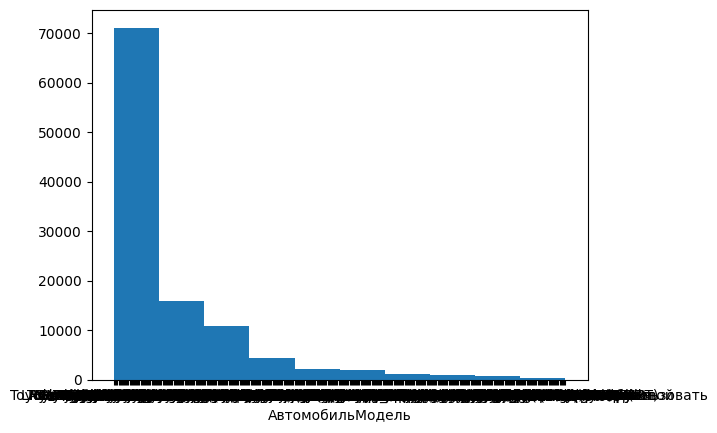

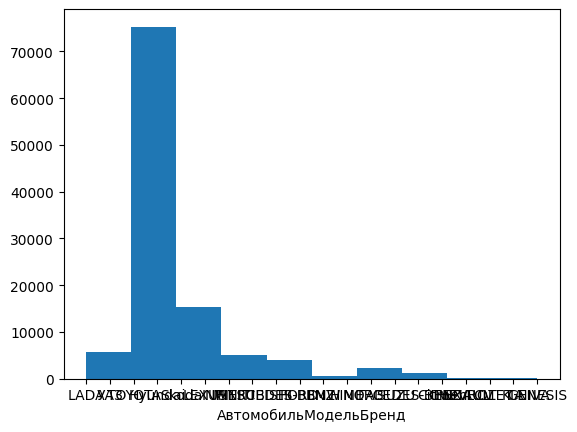

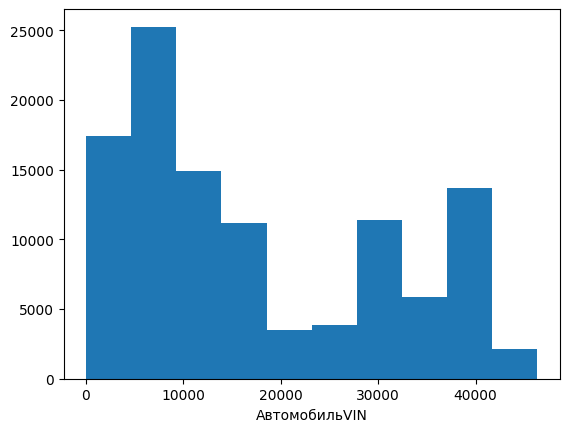

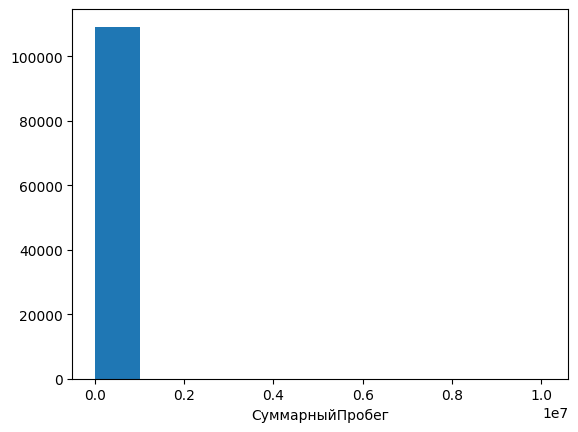

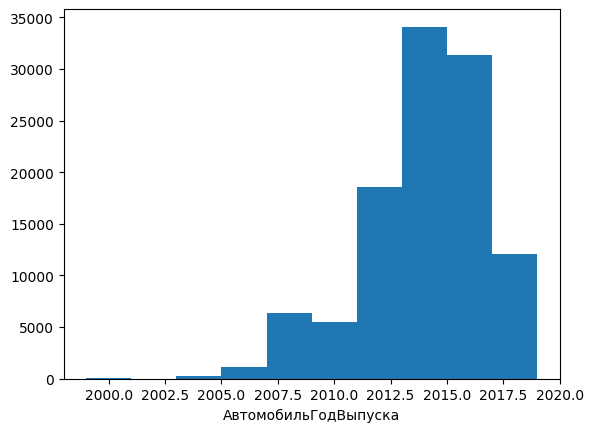

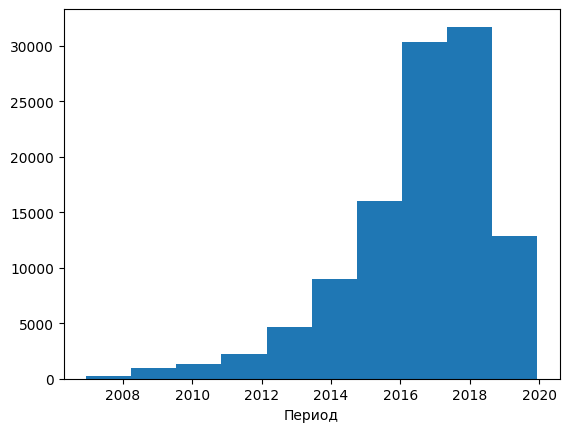

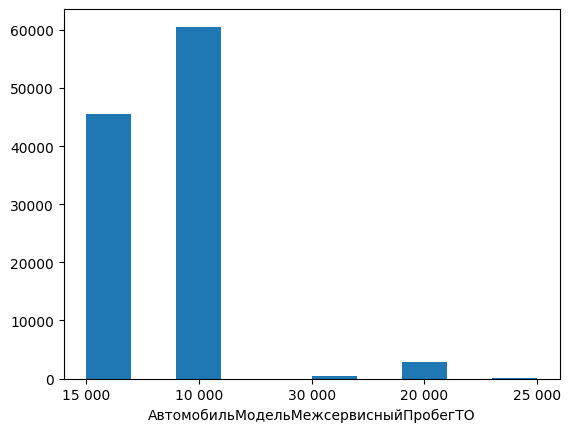

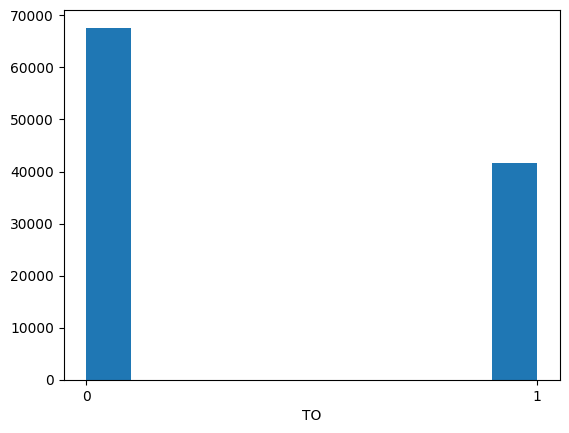

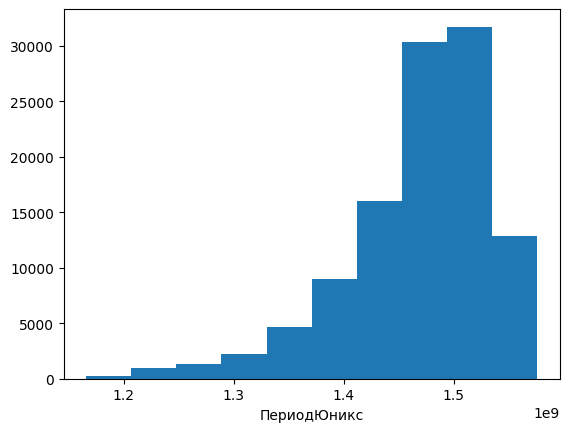

In [20]:
#Неожиданная проблема с пробелом, но я справился
df_train['СуммарныйПробег'] = df_train['СуммарныйПробег'].str.replace("\xa0", "").fillna('0').astype('int64')
#Вывожу гистограмму
for col in df_train.columns:
    plt.hist(df_train[col])
    plt.xlabel(col)
    plt.show()

Наблюдения:

1. Преобладают автомобили марки toyota

2. Пробег большинства автомобилей не превышает 120 000 км. Также присутсвуют подозрительно высокие значения

3. Большинство автомобилей выпущено в период между 2014 и 2019 годом

4. Подавляющее большинство автомобилей обязаны проводить ТО после 10 000 или 15 000 км пробега

5. Соотношение прочих визитов к ТО равно примерно 3/2

In [21]:
#Изучаю подозрительные значения
print(df_train['СуммарныйПробег'].sort_values().tail(40))

29746       641256
108118      642489
107147      676767
107148      676767
1507        690000
15843       697797
15844       702512
28887       725000
56300       752700
56301       753500
108119      763341
53548       763341
53549       763341
1508        780150
80681       791548
80682       799548
26114       799548
28888       809750
53550       821201
53551       835260
1509        837150
26115       842783
108120      847877
102278      852302
80683       861250
26116       861250
53552       865709
80685       869907
53553       871948
53554       880269
26117       891810
80686       901876
26118       906574
108121      910896
33882      1040421
33883     10007717
61196     10070244
88282     10080563
88283     10090651
33884     10099765
Name: СуммарныйПробег, dtype: int64


Явно выделяются пять значений с пробегом больше 10 млн.км, скорей всего там случайно добавили ноль

In [22]:
#Редактирую проблемные строки
df_train.loc[(df_train['СуммарныйПробег']>10000000),['СуммарныйПробег']] = df_train.loc[(df_train['СуммарныйПробег']>10000000),['СуммарныйПробег']]*0.1
df_train['СуммарныйПробег'] = df_train['СуммарныйПробег'].astype('int64')

In [23]:
#Смотрю корреляцию категориальных признаков
df_train = df_train.apply(
        lambda x: x.astype("category") if x.dtype == "O" else x)
cramersv = am.CramersV(df_train) 
cramersv.fit()

,АвтомобильМодель,АвтомобильМодельБренд,АвтомобильVIN,АвтомобильМодельМежсервисныйПробегТО,ТО
АвтомобильМодель,1.000000,1.000000,1.000000,1.000000,0.140374
АвтомобильМодельБренд,1.000000,1.000000,1.000000,0.837812,0.093034
АвтомобильVIN,1.000000,1.000000,1.000000,1.000000,0.378559
АвтомобильМодельМежсервисныйПробегТО,1.000000,0.837812,1.000000,1.000000,0.055227
ТО,0.140374,0.093034,0.378559,0.055227,1.000000


In [24]:
#Смотрю корреляцию числовых признаков
df_train.corr()

,СуммарныйПробег,АвтомобильГодВыпуска,ПериодЮникс
СуммарныйПробег,1.000000,-0.393050,0.146206
АвтомобильГодВыпуска,-0.393050,1.000000,0.635515
ПериодЮникс,0.146206,0.635515,1.000000


Касательно корреляции: Многие категориальные признаки связаны между собой, стоит сократить их число. Также я считаю, что раз уж моё задание касается прогнозирования техосмотра, то мне нужно удалить все строки, в которых, находятся визиты, не относящиеся к ТО.

Кроме того, я считаю, что после удаления всех лишних столбцов, останется слишком мало информации, поэтому я хочу придумать несколько новых признаков

## Подготовка данных

Мой план заключается в том, чтобы создать таргет с датой последнего визита автомобиля, и иметь дату предпоследнего визита в качестве одного из признаков

In [25]:
#Создаю новые признаки
df_train = df_train.reset_index(drop = True)
df_train['ВозрастАвтомобиля'] = df_train['Период'].dt.year.astype('int64') - df_train['АвтомобильГодВыпуска']
df_train['ПоследнийВизит'] = df_train['ПериодЮникс']
df_train['ПоследнийПробег'] = df_train['СуммарныйПробег']
df_train['СреднийПромежуток'] = df_train['ПериодЮникс']
df_train['СреднийПробег'] = df_train['СуммарныйПробег']
df_train['АвтомобильМодельМежсервисныйПробегТО'] = df_train['АвтомобильМодельМежсервисныйПробегТО'].str.replace("\xa0", "").astype('int64')
#Да, я понимаю, что это не самое изящное решение, но мне пока что трудно придумать более эффективную реализацию
for i in range(len(df_train)):
    df_train.loc[i,'ПоследнийВизит'] = df_train['ПериодЮникс'].loc[df_train['АвтомобильVIN'] == df_train.loc[i,'АвтомобильVIN']].max()
    df_train.loc[i,'ПоследнийПробег'] = df_train['СуммарныйПробег'].loc[df_train['АвтомобильVIN'] == df_train.loc[i,'АвтомобильVIN']].max()
    df_train.loc[i,'СреднийПромежуток'] = df_train['ПериодЮникс'].loc[df_train['АвтомобильVIN'] == df_train.loc[i,'АвтомобильVIN']].sum()/df_train['ПериодЮникс'].loc[df_train['АвтомобильVIN'] == df_train.loc[i,'АвтомобильVIN']].count()
    df_train.loc[i,'СреднийПробег'] = df_train['СуммарныйПробег'].loc[df_train['АвтомобильVIN'] == df_train.loc[i,'АвтомобильVIN']].sum()/df_train['СуммарныйПробег'].loc[df_train['АвтомобильVIN'] == df_train.loc[i,'АвтомобильVIN']].count()
df_train['СреднийПробег'] = df_train['СреднийПробег'].astype('int64')
df_train = df_train.drop(['АвтомобильМодель','АвтомобильМодельБренд','Период'],axis=1)

In [26]:
#Создаю столбец с предпоследним визитом
df_train_old = df_train.copy()
df_train = df_train[df_train['ТО']=='1']
df_train = df_train.drop(['ТО'], axis=1)
df_train = df_train[df_train.ПоследнийВизит != df_train.ПериодЮникс]
df_train = df_train[df_train.ПоследнийПробег != df_train.СуммарныйПробег]
df_train = df_train.reset_index(drop = True)
df_train['ПредпоследнийВизит'] = df_train['ПоследнийВизит']
df_train['ПредпоследнийПробег'] = df_train['ПоследнийПробег']
for i in range(len(df_train)):
    df_train.loc[i,'ПредпоследнийВизит'] = df_train['ПериодЮникс'].loc[df_train['АвтомобильVIN'] == df_train.loc[i,'АвтомобильVIN']].max()
    df_train.loc[i,'ПредпоследнийПробег'] = df_train['СуммарныйПробег'].loc[df_train['АвтомобильVIN'] == df_train.loc[i,'АвтомобильVIN']].max()

In [27]:
#Разделяю на выборки
train_target_time = df_train['ПоследнийВизит']
train_target_mileage = df_train['ПоследнийПробег']
train_features_time = df_train[['АвтомобильГодВыпуска','СреднийПромежуток','ПредпоследнийВизит','АвтомобильМодельМежсервисныйПробегТО','ВозрастАвтомобиля']]
train_features_mileage = df_train[['АвтомобильГодВыпуска','СреднийПробег','ПредпоследнийПробег','АвтомобильМодельМежсервисныйПробегТО','ВозрастАвтомобиля']]

In [28]:
#Произвожу масштабирование
scaler = StandardScaler()
train_features_time.loc[:,('СреднийПромежуток','ПредпоследнийВизит','АвтомобильГодВыпуска','АвтомобильМодельМежсервисныйПробегТО','ВозрастАвтомобиля')] = scaler.fit_transform(train_features_time.loc[:,('СреднийПромежуток','ПредпоследнийВизит','АвтомобильГодВыпуска','АвтомобильМодельМежсервисныйПробегТО','ВозрастАвтомобиля')])
train_features_mileage.loc[:,('СреднийПробег','ПредпоследнийПробег','АвтомобильГодВыпуска','АвтомобильМодельМежсервисныйПробегТО','ВозрастАвтомобиля')] = scaler.fit_transform(train_features_mileage.loc[:,('СреднийПробег','ПредпоследнийПробег','АвтомобильГодВыпуска','АвтомобильМодельМежсервисныйПробегТО','ВозрастАвтомобиля')])

In [29]:
train_features_time

,АвтомобильГодВыпуска,СреднийПромежуток,ПредпоследнийВизит,АвтомобильМодельМежсервисныйПробегТО,ВозрастАвтомобиля
0,0.200895,-0.198961,-0.509473,0.934952,-0.697881
1,0.925861,1.351957,0.644833,0.934952,-0.183567
2,0.563378,0.854141,0.790258,-0.738651,-0.697881
3,0.563378,0.854141,0.790258,-0.738651,0.330748
4,-0.886555,-1.386880,-0.789718,-0.738651,-0.183567
...,...,...,...,...,...
34541,-1.974005,-3.695142,-4.557118,-0.738651,-0.697881
34542,0.200895,0.081338,-0.242861,0.934952,-0.697881
34543,0.200895,0.081338,-0.242861,0.934952,-0.183567
34544,-0.886555,-0.160656,-0.348900,-0.738651,0.330748


## Подбор модели

Мой план таков: Протестировать четыре модели(лин.регрессию, lgbm, лес и катбуст) и подобрать параметры для самой лучшей. Тесты будут проходить через кросс-валидацию, для снижения фактора случайности

In [30]:
reg_model = LinearRegression()
scores = cross_val_score(reg_model, train_features_time,train_target_time, cv=5, scoring='neg_root_mean_squared_error')
print('Средняя ошибка в днях:',round(scores.mean()/86400*-1))
scores = cross_val_score(reg_model, train_features_mileage,train_target_mileage, cv=5, scoring='neg_root_mean_squared_error')
print('Средняя ошибка в километрах:',round(scores.mean()*-1))

Средняя ошибка в днях: 186
Средняя ошибка в километрах: 15717


In [31]:
lgbm_model = LGBMRegressor(random_state=21,force_row_wise=True)
scores = cross_val_score(lgbm_model, train_features_time,train_target_time, cv=5, scoring='neg_root_mean_squared_error')
print('Средняя ошибка в днях:',round(scores.mean()/86400*-1))
scores = cross_val_score(lgbm_model, train_features_mileage,train_target_mileage, cv=5, scoring='neg_root_mean_squared_error')
print('Средняя ошибка в километрах:',round(scores.mean()*-1))

[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 27636, number of used features: 5
[LightGBM] [Info] Start training from score 1519027628.310899
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 27637, number of used features: 5
[LightGBM] [Info] Start training from score 1519062244.150957
[LightGBM] [Info] Total Bins 557
[LightGBM] [Info] Number of data points in the train set: 27637, number of used features: 5
[LightGBM] [Info] Start training from score 1518838530.144372
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 27637, number of used features: 5
[LightGBM] [Info] Start training from score 1519340054.680320
[LightGBM] [Info] Total Bins 556
[LightGBM] [Info] Number of data points in the train set: 27637, number of used features: 5
[LightGBM] [Info] Start training from score 1518738799.840793
Средняя ошибка в днях: 143
[LightGBM] [Info] Total Bins 557
[Ligh

In [32]:
forest_model = RandomForestRegressor(random_state=21)
scores = cross_val_score(forest_model, train_features_time,train_target_time, cv=5, scoring='neg_root_mean_squared_error')
print('Средняя ошибка в днях:',round(scores.mean()/86400*-1))
scores = cross_val_score(forest_model, train_features_mileage,train_target_mileage, cv=5, scoring='neg_root_mean_squared_error')
print('Средняя ошибка в километрах:',round(scores.mean()*-1))

Средняя ошибка в днях: 72
Средняя ошибка в километрах: 6778


In [33]:
cat_model = CatBoostRegressor(random_state=21,logging_level = 'Silent')
scores = cross_val_score(cat_model, train_features_time,train_target_time, cv=5, scoring='neg_root_mean_squared_error')
print('Средняя ошибка в днях:',round(scores.mean()/86400*-1))
scores = cross_val_score(cat_model, train_features_mileage,train_target_mileage, cv=5, scoring='neg_root_mean_squared_error')
print('Средняя ошибка в километрах:',round(scores.mean()*-1))

Средняя ошибка в днях: 134
Средняя ошибка в километрах: 8512


In [34]:
#Подбор параметров
param_grid = {'max_depth': [10, 30, None],
 'min_samples_leaf': [None, 2, 4],
 'min_samples_split': [None, 5, 10],
 'n_estimators': [None, 1000]}
model_grid = GridSearchCV(forest_model, param_grid, cv=3, scoring = 'neg_root_mean_squared_error')
model_grid.fit(train_features_time,train_target_time)
print('Лучшие параметры:', model_grid.best_params_)
print('Лучший показатель по времени:',round(model_grid.best_score_/86400*-1))
model_grid.fit(train_features_mileage,train_target_mileage)
print('Лучшие параметры:', model_grid.best_params_)
print('Лучший показатель по пробегу:',round(model_grid.best_score_*-1))

Лучшие параметры: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1000}
Лучший показатель по времени: 91
Лучшие параметры: {'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 1000}
Лучший показатель по пробегу: 8744


Оказалось, что наилучший результат даёт случайный лес со стандартными параметрами, он и будет использован далее

## Финальный тест

In [35]:
#Привожу данные в подходящий формат
test_features_time = df_test[['АвтомобильVIN']]
test_features_time = test_features_time.join(df_train_old[['СреднийПромежуток','ПоследнийВизит','АвтомобильГодВыпуска','АвтомобильМодельМежсервисныйПробегТО','ВозрастАвтомобиля']],test_features_time['АвтомобильVIN'],'left')
test_target_time = pd.to_datetime(df_test['Период']).map(lambda x: x.replace(tzinfo=timezone.utc).timestamp())
test_target_mileage = df_test['Значение'].str.replace("\xa0",'').astype('int64')

In [36]:
#Обнаружены пропуски, выясняю их количество
test_features_time.isna().sum()

АвтомобильVIN                           0
СреднийПромежуток                       0
ПоследнийВизит                          0
АвтомобильГодВыпуска                    0
АвтомобильМодельМежсервисныйПробегТО    0
ВозрастАвтомобиля                       0
dtype: int64

По всей видимости, пропуски появились из-за новых автомобилей, которых не было в тренировочной выборке, я считаю, что  разумно будет заполнить пропуски максимальным значением по 'Последнему визиту'

In [37]:
test_features_time = test_features_time.fillna(test_features_time['ПоследнийВизит'].max()).drop(['АвтомобильVIN'],axis = 1)

In [38]:
#Повторяю процесс для пробега, но пропуски заполняю медианной
test_features_mileage = df_test[['АвтомобильVIN']]
test_features_mileage = test_features_mileage.join(df_train_old[['СреднийПробег','ПоследнийПробег','АвтомобильГодВыпуска','АвтомобильМодельМежсервисныйПробегТО','ВозрастАвтомобиля']],test_features_mileage['АвтомобильVIN'],'left')
test_features_mileage = test_features_mileage.drop(['АвтомобильVIN'],axis = 1)
test_features_mileage['СреднийПробег'] = test_features_mileage['СреднийПробег'].fillna(test_features_mileage['СреднийПробег'].median())
test_features_mileage['ПоследнийПробег'] = test_features_mileage['ПоследнийПробег'].fillna(test_features_mileage['ПоследнийПробег'].median())
test_features_mileage[['СреднийПробег','ПоследнийПробег']] = test_features_mileage[['СреднийПробег','ПоследнийПробег']].astype('int64')

In [39]:
#Произвожу масштабирование
test_features_time.loc[:,('СреднийПромежуток','ПоследнийВизит','АвтомобильГодВыпуска','АвтомобильМодельМежсервисныйПробегТО')] = scaler.fit_transform(test_features_time.loc[:,('СреднийПромежуток','ПоследнийВизит','АвтомобильГодВыпуска','АвтомобильМодельМежсервисныйПробегТО')])
test_features_mileage.loc[:,('СреднийПробег','ПоследнийПробег','АвтомобильГодВыпуска','АвтомобильМодельМежсервисныйПробегТО')] = scaler.fit_transform(test_features_mileage.loc[:,('СреднийПробег','ПоследнийПробег','АвтомобильГодВыпуска','АвтомобильМодельМежсервисныйПробегТО')])

In [40]:
forest_model.fit(train_features_mileage,train_target_mileage)
mileage_predictions = forest_model.predict(test_features_mileage)
print('Точность предсказания пробега:',round(mean_squared_error(test_target_mileage,mileage_predictions, squared = False)))
forest_model.fit(train_features_time,train_target_time)
time_predictions = forest_model.predict(test_features_time)
print('Точность предсказания даты:',round(mean_squared_error(test_target_time,time_predictions, squared = False)/86400))

Точность предсказания пробега: 163472
Точность предсказания даты: 780


Задание выполнено, но результат оказался ниже ожидаемого. Точность оказалось слишком низкой для использования в деле

In [41]:
#Эту ячейку я использую для отслеживания feature importance при разных добавленных признаках
feature_scores = pd.Series(forest_model.feature_importances_, index=test_features_time.columns).sort_values(ascending=False)

feature_scores

АвтомобильГодВыпуска                    0.915764
ПоследнийВизит                          0.067842
СреднийПромежуток                       0.011376
АвтомобильМодельМежсервисныйПробегТО    0.003632
ВозрастАвтомобиля                       0.001386
dtype: float64